**Métodos Computacionales I**

**Universidad de los Andes**


## Integración con Metropolis-Hastings

Dada una distribuón $g(x)$ y una función $f(x)$ se tiene que

$$ \frac{\int g(x)f(x)dx}{\int f(x)dx} = \left< g(x) \right> \approx \frac{1}{N} \sum_{i=1}^{N} g(x_{i}) $$

Si se tiene una integral que se pueda escribir en la forma $\int g(x)f(x)dx$, se puede hacer uso del algoritmo de Metropolis-Hastings para encontrar el valor de dicha integral si se calcula o se sabe $\int f(x)dx$ (que suele llamarse factor de normalización)

$$I = \int g(x)f(x)dx \approx \frac{\int f(x)dx}{N}\sum_{i = 1}^{N}g(x_{i})$$


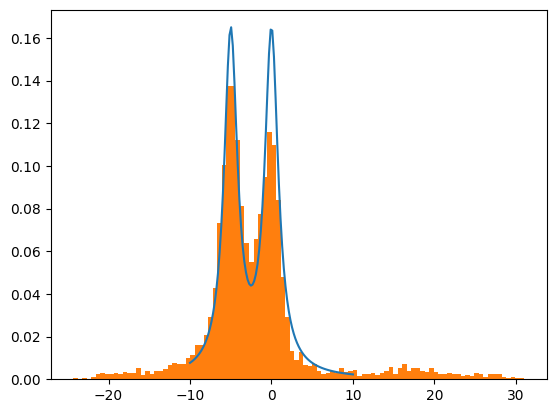

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
  return (1/2)*(1/(np.pi*(1 + x**2)) + 1/(np.pi*(1 + (x+5)**2)))

x_0 = 1.1

puntos = []
iters = 10000

for i in range(iters):
  x_1 = x_0 + np.random.normal(0, 1)
  a = f(x_1)/f(x_0)

  if a > 1:
    x_0 = x_1
    puntos.append(x_0)
  else:
    if a > np.random.rand():
      x_0 = x_1
      puntos.append(x_0)

puntos
x = np.linspace(-10, 10, 100)
y = f(x)
plt.plot(x, y)
plt.hist(puntos, bins = 100, density = True)
plt.show()

In [ ]:
def g(x):
  return x[0]

def p(x):
  xp = x**2
  return np.exp(-(-8*np.sum(x)+np.prod(xp) + np.sum(xp))*0.5)

x_0 = np.array([1., 2.])

puntos = []
iters = 100000

for i in range(iters):
  x_1 = x_0 + np.random.normal(0, 0.5, 2)
  a = p(x_1)/p(x_0)

  if a > 1:
    x_0 = x_1
    puntos.append(x_0)
  else:
    if a > np.random.rand():
      x_0 = x_1
    puntos.append(x_0)

int_temp = g(np.array(puntos))
integral = int_temp.mean()

integral

1.7496496910833965

**Ejemplo:** Use Metropolis-Hasting para estimar el valor de la integral

$$I = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}  x\frac{e^{-\frac{1}{2}(-8x-8y+x^2y^2+x^2+y^2)}}{C}dxdy$$

Donde la constante de normalización $C\approx 20216.336$

In [ ]:
#implementación para de la integración de Metropolis-hastings en n dimensiones
import numpy as np

def integracion_metropolis(p,g,dimension, steps):
  v_gx = np.zeros(steps)
  old_x = np.ones(dimension)
  old_prob = p(old_x)

  for i in range(steps):
    new_x = np.random.normal(old_x, 0.5,dimension)
    new_prob = p(new_x)
    aceptacion = new_prob / old_prob
    if aceptacion > np.random.rand():
      old_x = new_x
      old_prob = new_prob
    v_gx[i] = g(old_x)

  return np.mean(v_gx), 2*np.std(v_gx)/np.sqrt(steps)

def g(x):
  return x[0]

def p(x):
  xp = x**2
  return np.exp(-(-8*np.sum(x)+np.prod(xp) + np.sum(xp))*0.5)

integracion_metropolis(p,g,2,100000)

(1.7713481827422553, 0.0103460909365267)

## Estimación de parámetros con Metropolis-Hastings

Suponga que tiene datos $D (t_i)$,  (ya sea un escalar o un vector) en puntos discretos $t_i$ y un modelo propuesto, que produce una serie $y (t | \theta)$, donde $\theta$ representa un conjunto de parámetros libres que cambia la función propuesta.

Lo primero que debe hacer es elegir una función de error. El más común es la suma de errores cuadrados dada por

$$\chi ^ 2 = \sum_i \frac {(D (t_i) -y (t_i | \theta)) ^ 2} {2 \sigma ^ 2}$$

donde $\sigma$ es una estimación del error de los datos. Usualmente, puede utilizar la incertidumbre experimental o simplemente adivinar.

Lo que se desea es que la probabilidad $P$ sea máxima cuando $\chi^2$ sea mínimo. Esto lo podemos plasmar por ejemplo así

$$
P(D | \theta) = e^{- \chi ^ 2}
$$

(Esto puede generar números que estan por fuera del rango de presición de python, si esto ocurre puede remplasar la función exponencial por otra que no cause este problema, o asegurarse de que sus valores iniciales para los parámetros no esten muy lejos de los valores buscados)

In [ ]:
def model(t,c):
  return c[0]*t + c[1]

def p(t,D,model, theta):
  sigma = 1
  chi2 = np.sum((D - model(t,theta))**2)/(2*sigma**2)
  return np.exp(-chi2)

theta_0 = np.array([1., 2.])

t = np.linspace(0,10,num=11) ### los puntos x
D = 0.1*t + 7 + np.random.normal(0, 0.05, 11) #### puntos y


puntos = []
iters = 100000

for i in range(iters):
  theta_1 = theta_0 + np.random.normal(0, 1.0, 2)
  a = p(t, D, model, theta_1)/p(t, D, model, theta_0)

  if a > 1:
    theta_0 = theta_1
    puntos.append(theta_0)
  else:
    if a > np.random.rand():
      theta_0 = theta_1
    puntos.append(theta_0)

puntos_array = np.array(puntos)

puntos_array, puntos_array.mean(axis = 0)



(array([[0.36146635, 3.74865199],
        [0.36146635, 3.74865199],
        [0.36146635, 3.74865199],
        ...,
        [0.12985609, 6.9751824 ],
        [0.12985609, 6.9751824 ],
        [0.12985609, 6.9751824 ]]),
 array([0.09685716, 7.00907151]))

In [ ]:
import numpy as np

def metropolis_fit(p,t,D,model,theta,steps):
  dimension = len(theta)
  muestras = np.zeros([dimension,steps])
  probabilidad = np.zeros([dimension,steps])
  old_theta = theta
  old_prob = p(t,D,model, old_theta)

  for i in range(steps):
    new_theta = old_theta + np.random.normal(0, 0.5, dimension)
    new_prob = p(t,D,model, new_theta)
    aceptacion = new_prob / old_prob

    if aceptacion > np.random.rand():
      old_theta = new_theta
      old_prob = new_prob

    muestras[:,i] = old_theta
    probabilidad[:,i] = old_prob

  return muestras, probabilidad

**Ejemplo:** Ajustar con un modelo lineal los datos generados con `t = np.linspace(0,10,num=11)` y con `D = 0.1*t + 7`. Ignorar los primeros 1000 samples.




In [ ]:
def model(t,c):
  return c[0]*t + c[1]

def p(t,D,model, theta):
  sigma = 1
  chi2 = np.sum((D - model(t,theta))**2)/(2*sigma**2)
  return np.exp(-chi2)

def calcular_parametro(samples,inicio,dimension):
  return np.mean(samples[dimension,ignora:])

def mostrar_histograma(samples,inicio,dimension):
  print('c{}:'.format(dimension),calcular_parametro(samples,inicio,dimension))
  plt.hist(samples[dimension,ignora:], bins=50)
  plt.show()

def mostrar_ajuste(t,D,samples,inicio):
  c0 = calcular_parametro(samples,inicio,0)
  c1 = calcular_parametro(samples,inicio,1)
  print(c0,c1)
  y = c0*t + c1
  plt.plot(t,D,'o')
  plt.plot(t,y,c='r')
  plt.show()

t = np.linspace(0,10,num=11)
D = 0.1*t + 7 + np.random.normal(0, 0.05, 11)
dimensiones = 2
steps = 100000
theta = np.ones(dimensiones)
samples, probabilidad = metropolis_fit(p,t,D,model,theta,steps)

c0: 0.09841775303474302


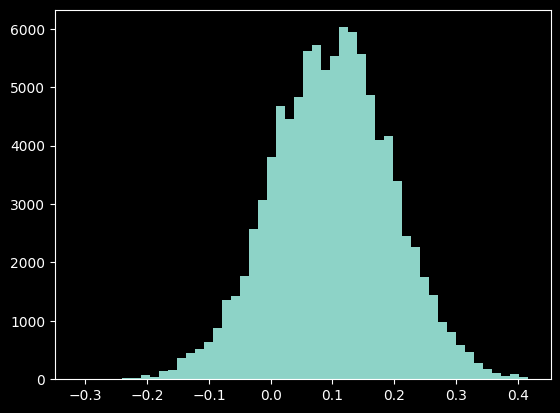

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

dimension = 0
ignora = 1000
mostrar_histograma(samples,ignora,dimension)

c1: 6.990885856428511


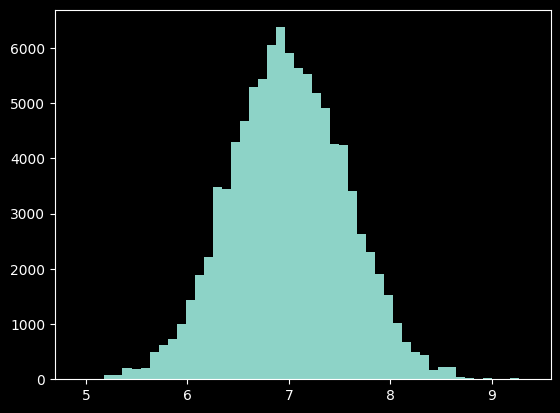

In [ ]:
dimension = 1
ignora = 1000
mostrar_histograma(samples,ignora,dimension)

0.09841775303474302 6.990885856428511


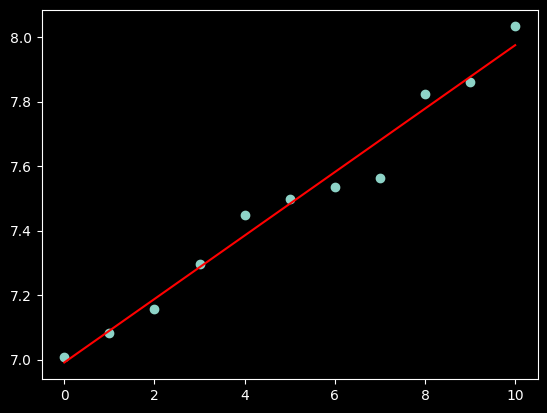

In [ ]:
mostrar_ajuste(t,D,samples,ignora)

**References**

**Profesor: Diego Alberto Castro Rodríguez**